In [ ]:
import numpy as np
import picos as pic
from SDP import HelperFunctionsforNotebook5 as crp 
from qutipy.entropies import coherent_inf_channel
import matplotlib.pyplot as plt

The quantum capacity of a quantum channel $\mathcal{N}$ is given by the regularized $$Q(\mathcal{N}) = \lim_{n \to \infty} \frac{1}{n} \max_{\rho} I_c(\mathcal{N}^{\otimes n},\rho),$$ where $I_c$ is the coherent information. Generally, the quantum capacity of a quantum channel is a difficult quantity to compute. This is due to the phenomenon of non-additivity, which means that the regularized expression does not reduce to a single letter formula. 

As explained in [1], degradable channels are a class of quantum channels for which the quantum capacity can be computed from the coherent information of one channel use. This makes evaluating the quantum capacity of such channels much easier than evaluating the capacity for general channels. 
In [2], it is shown that an upper bound on the quantum capacity of a general channel $\mathcal{N}$ can be obtained as a function of the coherent information of one channel use $Q^{(1)}(\mathcal{N})$ and a degradability parameter $\epsilon$, expressing the distance to the nearest degradable channel. With $d_c$ being the dimension of the environment, the bound is given by
$$Q^{(1)}(\mathcal{N}) \leq Q(\mathcal{N})\leq Q^{(1)}(\mathcal{N})+\frac{\epsilon}{2} \log(d_c-1)+h(\epsilon/2)+\epsilon \log_2(d_c)+(1+\epsilon/2)h(\frac{\epsilon}{2+\epsilon}).$$

[1] Five Starter Pieces: Quantum Information Science via Semi-definite Programs. Vikesh Siddhu, Sridhar Tayur. https://arxiv.org/abs/2112.08276 
[2] Approximate Degradable Quantum Channels. David Sutter, Volkher B. Scholz, Andreas Winter, Renato Renner. https://arxiv.org/abs/1412.0980


A quantum channel can be expressed in terms of its Kraus operators $\{K_i\}$, $\mathcal{N}(\rho)=\sum_i K_i \rho K_i^\dagger.$
The number of Kraus operators is the environment dimension and is denoted by $d_c$. 

Consider a Pauli channel: $\mathcal{N}(\rho)=p_I \rho + p_X X \rho X + p_Y Y \rho Y + p_Z Z \rho Z,$ where $X,Y,Z$ are the Pauli matrices. The Kraus operators of this channel are given by $\{K_i\}=\{\sqrt{p_I}I, \sqrt{p_X}X, \sqrt{p_Y}Y, \sqrt{p_Z}Z\}.$ If any $p_i=0$, the corresponding Kraus operator is not included in the list.

In [ ]:
def PauliChannelKraus(pX,pY,pZ):
    """
    Returns the Kraus operators for a Pauli channel with probabilities pX, pY, pZ
    """
    KrausList = []
    if(1-pX-pY-pZ>0):
        K0 = np.sqrt(1-pX-pY-pZ)*np.eye(2)
        KrausList.append(K0)
    if(pX>0):    
        K1 = np.sqrt(pX)*np.array([[0,1],[1,0]])
        KrausList.append(K1)
    if(pY>0):
        K2 = np.sqrt(pY)*np.array([[0,-1j],[1j,0]])
        KrausList.append(K2)
    if(pZ>0):
        K3 = np.sqrt(pZ)*np.array([[1,0],[0,-1]])
        KrausList.append(K3)
    return KrausList

The following function computes the degradability parameter $\epsilon$ for a given channel expressed in terms of its Kraus operators.


In [ ]:
def degradability_parameter(KrausList):
    
    (dc,db,da) = np.shape(KrausList)
    #Choi-Jamiolkowski representations of channel and its complement 
    (jbaF, jcaF) = crp.krausToChoiJ(KrausList)

    #Constants
    #----------
    JbaFPic = pic.Constant("J(B)_ba", jbaF)
    JcaFPic = pic.Constant("J(B)_ca", jcaF)
    
    iMatA = pic.Constant('Ia', np.eye(da))
    iMatB = pic.Constant('Ib', np.eye(db))
    shpCA = (dc*da,dc*da)
    shpCB = (dc*db,dc*db)
    
    
    #Variables
    #----------
    ZPic = pic.HermitianVariable("Zca", shpCA)
    JPic = pic.HermitianVariable("Jcb", shpCB)
    mu = pic.RealVariable("mu")
    
    prob1P = pic.Problem()

    #Constraint
    #----------
    prob1P.add_constraint(ZPic >> 0)
    prob1P.add_constraint(JPic >> 0)
    
    ZaPic = pic.partial_trace(ZPic,subsystems=(0), dimensions=(dc,da))
    JbPic = pic.partial_trace(JPic,subsystems=(0), dimensions=(dc,db))
    
    prob1P.add_constraint(ZaPic << mu*iMatA)
    prob1P.add_constraint(JbPic == iMatB)
    
    JcaPic = crp.choiJOfChanInSeriesPic(JbaFPic,JPic,da,db,dc)
    prob1P.add_constraint(ZPic >> JcaFPic-JcaPic)
    
    #Objective
    #----------
    prob1P.set_objective('min',mu)

    prob1P.solve(verbosity=False,solver='cvxopt')
    
    #Solver claims to have found optimal solution
    mu1P =  prob1P.value
    eps1 = 2*mu1P
    return eps1



In [ ]:
def h(p):
    """
    Returns the binary entropy function h(p) = -p log_2(p) - (1-p) log_2(1-p)
    """
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p) - (1-p)*np.log2(1-p)

The following function computes the upper bound on the quantum capacity of a Pauli channel with probabilities $p_X, p_Y, p_Z$ using the formula from [Theorem 3.4, 2].

In [ ]:
def quantum_capacity_upper_bound_Pauli_channel(pX,pY,pZ):
    """
    Returns an upper bound on the quantum capacity of a Pauli channel with probabilities pX, pY, pZ
    """
    KrausList = PauliChannelKraus(pX,pY,pZ)
    eps = degradability_parameter(KrausList)
    (d_c,d_b,d_a) = np.shape(KrausList)
    Q1 = coherent_inf_channel(KrausList,dim_in=d_a,dim_out=d_b)
    Q = Q1 + eps/2*np.log(d_c-1) + h(eps/2) + eps*np.log2(d_c) + (1+eps/2)*h(eps/(2+eps))
    return Q
    

As an example, we plot the upper bound on the quantum capacity of the BB84 Pauli channel discussed in [Section 5B,2]: 
$$\mathcal{N}(\rho)=(1-p_X-p_Z+p_Xp_Z)\rho+(p_X-p_Z p_X) X\rho X+(p_Z-p_Zp_X) Z \rho Z + p_Xp_Z Y\rho Y,$$ with $p_Z=100p_X$.

In [63]:
prange = np.arange(0,1e-3,1e-5)
UB = [quantum_capacity_upper_bound_Pauli_channel(p-100*p**2,100*p**2,100*p-100*p**2) for p in prange]


Optimization terminated successfully.
         Current function value: -0.961736
         Iterations: 7
         Function evaluations: 90
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: -0.953799
         Iterations: 5
         Function evaluations: 54
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: -0.946157
         Iterations: 6
         Function evaluations: 63
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: -0.938760
         Iterations: 5
         Function evaluations: 54
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: -0.931574
         Iterations: 5
         Function evaluations: 63
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: -0.924572
         Iterations: 7
         Function evaluations: 108
     

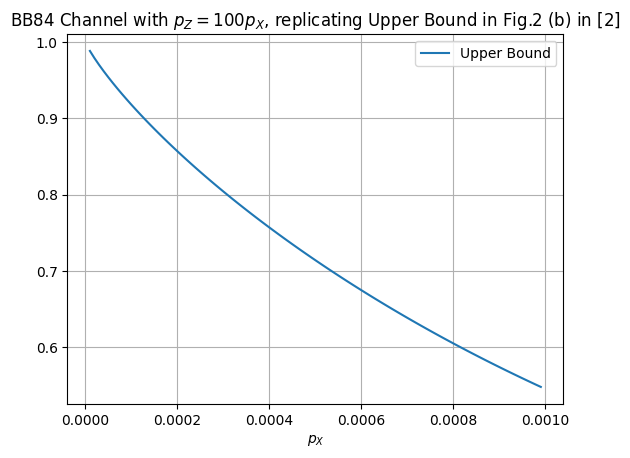

In [64]:
plt.plot(prange,UB,label='Upper Bound')
plt.title('BB84 Channel with $p_Z = 100 p_X$, replicating Upper Bound in Fig.2 (b) in [2]')
plt.grid()
plt.xlabel('$p_X$')
plt.legend()